In [43]:
import numpy as np
from utils import oned_well, functions
import matplotlib.pyplot as plt
from alive_progress import alive_bar

In [44]:
import multiprocessing


def _unpacking_apply_along_axis(all_args):
    """
    Like numpy.apply_along_axis(), but with arguments in a tuple
    instead.

    This function is useful with multiprocessing.Pool().map(): (1)
    map() only handles functions that take a single argument, and (2)
    this function can generally be imported from a module, as required
    by map().
    """
    (func1d, axis, arr, args, kwargs) = all_args
    return np.apply_along_axis(func1d, axis, arr, *args, **kwargs)


def parallel_apply_along_axis(func1d, axis, arr, *args, **kwargs):
    """
    Like numpy.apply_along_axis(), but takes advantage of multiple
    cores.
    """
    # Effective axis where apply_along_axis() will be applied by each
    # worker (any non-zero axis number would work, so as to allow the use
    # of `np.array_split()`, which is only done on axis 0):
    effective_axis = 1 if axis == 0 else axis
    if effective_axis != axis:
        arr = arr.swapaxes(axis, effective_axis)

    # Chunks for the mapping (only a few chunks):
    chunks = [
        (func1d, effective_axis, sub_arr, args, kwargs)
        for sub_arr in np.array_split(arr, multiprocessing.cpu_count())
    ]

    pool = multiprocessing.Pool()
    individual_results = pool.map(_unpacking_apply_along_axis, chunks)
    # Freeing the workers:
    pool.close()
    pool.join()

    return np.concatenate(individual_results)

In [45]:
generations = 50
generation_size = 100000
n_best = 100
n_variables = 50
well_length = 5

# TODO: añadir criterio de convergencia
# TODO: añadir sampleo para variables continuas que tenga en cuenta span(x)/dim(x)
# TODO: añadir un módulo de interpolación de una función analítica con los puntos de x
# TODO: añadir visualización de la pérdida
# TODO: paralelizar (ahora mismo me tardó 4:45 minutos para 50 generaciones, 1e5 individuos, 100 mejores y 50 variables)

with alive_bar(
    0, force_tty=True, bar=None, theme="scuba", stats=False, stats_end=False
) as bar:
    for generation in range(generations):
        bar()
        if generation == 0:
            population = np.random.random([generation_size, n_variables])
        # scores = np.apply_along_axis(oned_well.compute_z, 1, population) # Not parallel
        scores = parallel_apply_along_axis(oned_well.compute_z, 1, population)
        # max_scores_index = np.argpartition(scores, -n_best)[-n_best:] # (si fuese maximizar)
        min_scores_index = np.argpartition(scores, n_best)[:n_best]
        best_individuals = population[min_scores_index]
        best_individuals_mean = best_individuals.transpose().mean(axis=1)
        best_individuals_std = best_individuals.transpose().std(axis=1)
        population = np.random.normal(
            best_individuals_mean, best_individuals_std, [generation_size, n_variables]
        )
        bar.text(f"- generation best: {min(scores)}")

# scores = np.apply_along_axis(oned_well.compute_z, 1, population) # Not parallel
scores = parallel_apply_along_axis(oned_well.compute_z, 1, population)
best_score = min(scores)
best_individual = population[np.argmin(scores)]
print(best_score)

1 in 0.0s                                                                       


AttributeError: module 'numpy' has no attribute 'parallel_apply_along_axis'

In [41]:
def Psi_n(n):
    return (2 / well_length) ** 0.5 * np.sin(
        n * np.pi * np.linspace(0, well_length, n_variables) / well_length
    )


integral = 0
for i in range(len(best_individual)):
    integral = integral + (best_individual[i] ** 2) * (well_length / (n_variables - 1))

B = (1 / integral) ** 0.5
best_individual = B * best_individual

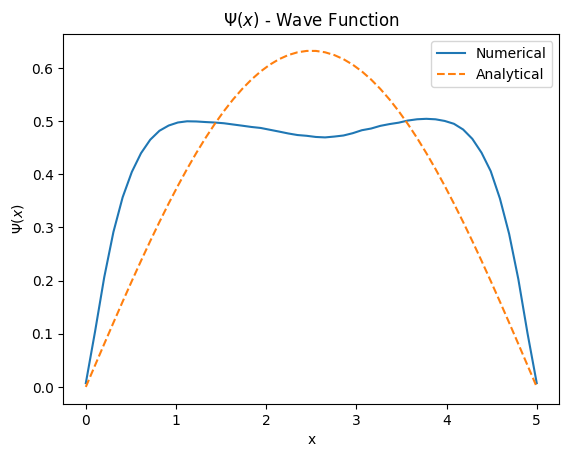

In [42]:
plt.plot(np.linspace(0, 5, n_variables), best_individual, label="Numerical")
plt.plot(np.linspace(0, 5, n_variables), Psi_n(1), "--", label="Analytical")
plt.gca().set_title("$\Psi(x)$ - Wave Function")
plt.gca().set_xlabel("x")
plt.gca().set_ylabel("$\Psi(x)$")
plt.legend()